In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import torch
import random

from sae.sparse_autoencoder import load_saved_sae
from sae.metrics import model_store_from_sae
from unlearning.metrics import convert_wmdp_data_to_prompt, convert_list_of_dicts_to_dict_of_lists
from unlearning.tool import UnlearningConfig, SAEUnlearningTool, MCQ_ActivationStoreAnalysis, ActivationStoreAnalysis
from unlearning.metrics import modify_and_calculate_metrics, calculate_metrics_list, create_df_from_metrics
from unlearning.feature_attribution import calculate_cache

from huggingface_hub import hf_hub_download
from datasets import load_dataset
import numpy as np
import pandas as pd
import itertools
from transformer_lens import utils

from jaxtyping import Float
from torch import Tensor

import einops

from pathlib import Path

import plotly.express as px
from unlearning.var import REPO_ID, SAE_MAPPING
import pickle

from unlearning.metrics import all_permutations

from unlearning.metrics import calculate_metrics_side_effects
from unlearning.feature_attribution import find_topk_features_given_prompt, test_topk_features


In [2]:
# Load main SAE for gemma-2b-it
filename = hf_hub_download(repo_id=REPO_ID, filename=SAE_MAPPING['gemma_2b_it_resid_pre_9'])
sae = load_saved_sae(filename)
model = model_store_from_sae(sae)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b-it into HookedTransformer
Moving model to device:  cuda


In [3]:
# pass in the dataset as an argument so no need to load in everytime
dataset = load_dataset("cais/wmdp", "wmdp-bio", split='test')

answers = [x['answer'] for x in dataset]
questions = [x['question'] for x in dataset]
choices_list = [x['choices'] for x in dataset]

prompts = [convert_wmdp_data_to_prompt(question, choices, prompt_format=None)
           for question, choices in zip(questions, choices_list)]


In [4]:
# Hyper parameters for automation process
question_ids_correct = np.genfromtxt("../data/question_ids/gemma-2b-it/all/wmdp-bio_correct.csv", dtype=int)
questions_ids_correct_train = np.genfromtxt("../data/question_ids/gemma-2b-it/train/wmdp-bio_correct.csv", dtype=int)
topk_per_prompt = 20

unlearning_dataset = ['wmdp-bio']
side_effect_dataset_names =  ['high_school_us_history', 'college_computer_science', 'high_school_geography', 'human_aging', 'college_biology']
all_dataset_names = ['loss_added', 'wmdp-bio', 'high_school_us_history', 'college_computer_science', 'high_school_geography', 'human_aging', 'college_biology']


In [5]:
feature_ids_zero_side_effect_sorted = np.genfromtxt("../eoin_notebooks/feature_ids_zero_side_effect_sorted_gemma1_2b_all.csv")

In [7]:
import matplotlib as mpl
from cycler import cycler

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 1.4

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 0.4
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 0.4
mpl.rcParams['ytick.minor.width'] = 0.4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10


mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 9

mpl.rcParams['figure.figsize'] = 6, 4

mpl.rcParams['axes.prop_cycle'] = cycler("color", ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plotting
fig_dir = "../figs"

def create_lineplot_histogram(distribution, bins=20):
    vals, bin_edges = np.histogram(distribution, bins=bins)

    xvals = np.repeat(bin_edges, 2)
    yvals = np.repeat(vals, 2)
    yvals = np.concatenate(([0], yvals, [0]))

    return xvals, yvals

In [8]:
feature_ids_zero_side_effect_sorted, len(feature_ids_zero_side_effect_sorted)

(array([13431.,  7983.,  4342.,  6308., 15642., 11358.,  8660.,  9473.,
         9163.,  8596., 10051., 12044., 12273., 13443.,  5205.,  4654.,
         1557.,    32., 15755.,  7076.,  5525.,  4071.,  4687., 11147.,
         3599.,  5861.]),
 26)

In [9]:
activation_store = ActivationStoreAnalysis(sae.cfg, model)

buffer
dataloader


In [ ]:
all_dataset_names = ['loss_added', 'wmdp-bio', 'high_school_us_history', 'college_computer_science', 'high_school_geography', 'human_aging', 'college_biology']


In [34]:
# Calculate metrics

main_ablate_params = {
                      'multiplier': 30,
                      'intervention_method': 'clamp_feature_activation',
                     }


sweep = {
         'features_to_ablate': [feature_ids_zero_side_effect_sorted[:i+1] for i in range(0, 25, 1)],
         'multiplier': [20],
        }

metric_params = {'wmdp-bio': 
                 {
                       'target_metric': 'correct',
                       'permutations': None,
                       'verbose': False,
                   },
                 # 'high_school_us_history':
                 # {
                 #     'target_metrics': 'correct',
                 #     'verbose': False,
                 # },
                 }

dataset_names = all_dataset_names[:]

n_batch_loss_added = 50

metrics = calculate_metrics_list(model,
                                      sae,
                                      main_ablate_params,
                                      sweep,
                                      dataset_names=dataset_names,
                                      metric_params=metric_params,
                                      include_baseline_metrics=False,
                                      n_batch_loss_added=n_batch_loss_added,
                                      activation_store=activation_store,
                                      split='all')


100%|██████████| 3/3 [00:35<00:00, 11.81s/it]


## Template for Pareto Frontiers

In [22]:
from unlearning.var import gemma_2b_it_rmu_model_names

# load results
model_name = gemma_2b_it_rmu_model_names[0].split('/')[-1]
with open(f'../data/unlearn_results/gemma-2b-it/rmu/correct/{model_name}.pkl', 'rb') as f:
    results = pickle.load(f)

for dataset in results:
    print(f'{dataset}: {results[dataset]["mean_correct"]}')

wmdp-bio: 0.9941860437393188
high_school_us_history: 1.0
high_school_geography: 1.0
college_computer_science: 1.0
human_aging: 1.0
college_biology: 1.0


In [ ]:
data/unlearn_results/gemma-2b-it/rmu/correct/gemma_2b_it_rmu_10.pkl 

In [14]:
metrics_list_best_sorted[0]['wmdp-bio']['mean_correct']

0.6511628031730652

In [18]:
wmdp_bio_scores

[0.6511628031730652,
 0.6511628031730652,
 0.6569767594337463,
 0.6569767594337463,
 0.6569767594337463,
 0.6569767594337463,
 0.6511628031730652,
 0.6511628031730652,
 0.6511628031730652,
 0.6511628031730652]

In [19]:
loss_added_scores

[0.0002640390396118164,
 0.0005431413650512695,
 0.001460103988647461,
 0.0028223037719726563,
 0.003921799659729004,
 0.004552454948425293,
 0.005081319808959961,
 0.0075522947311401365,
 0.010283064842224122,
 -0.0008891105651855468]

In [16]:
import matplotlib.pyplot as plt

In [28]:
loss_added_scores

[0.4264706075191498,
 0.4264706075191498,
 0.4264706075191498,
 0.4264706075191498,
 0.4264706075191498,
 0.4264706075191498,
 0.4264706075191498,
 0.4264706075191498,
 0.4264706075191498,
 0.4215686321258545]

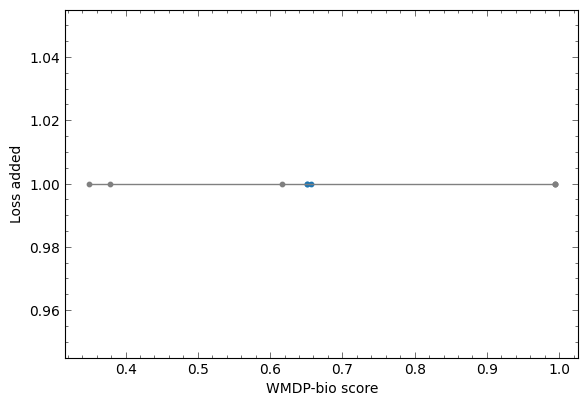

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))

wmdp_bio_scores = [x['wmdp-bio']['mean_correct'] for x in metrics]
side_effect = [x['high_school_us_history']['mean_correct'] for x in metrics]


ax.plot(wmdp_bio_scores, side_effect)
ax.scatter(wmdp_bio_scores, side_effect, marker='o', s=10)


# Plot RMU results

rmu_wmdp_bio_results = []
rmu_side_effect_results = []

for model_name in gemma_2b_it_rmu_model_names:
    model_name = model_name.split('/')[-1]
    with open(f'../data/unlearn_results/gemma-2b-it/rmu/correct/{model_name}.pkl', 'rb') as f:
        results = pickle.load(f)
    rmu_wmdp_bio_results.append(results['wmdp-bio']['mean_correct'])
    rmu_side_effect_results.append(results['high_school_us_history']['mean_correct'])
    
ax.plot(rmu_wmdp_bio_results, rmu_side_effect_results, color='grey')
ax.scatter(rmu_wmdp_bio_results, rmu_side_effect_results, s=10, marker='o', color='grey')



ax.legend()


# yticks = [-6, -5, -4, -3, -2, -1, 0]
# yticklabels = [r"10$^{-6}$", r"10$^{-5}$", r"10$^{-4}$", r"10$^{-3}$", 0.01, 0.1, 1]
# yminor_ticks = np.log10(np.concatenate((np.arange(1e-6, 1e-5, 1e-6),
#                                         np.arange(1e-5, 1e-4, 1e-5),
#                                         np.arange(1e-4, 1e-3, 1e-4),
#                                         np.arange(1e-3, 1e-2, 1e-3),
#                                         np.arange(1e-2, 1e-1, 1e-2),
#                                         np.arange(1e-1, 1, 1e-1))))

# ax.set_yticks(yticks)
# ax.set_yticklabels(yticklabels)
# ax.set_yticks(yminor_ticks, minor=True)


# xticks = [1, 2, 5, 10, 20, 50, 100]
# xticklabels = xticks
# xminor_ticks = np.log10(np.concatenate((np.arange(1, 10, 1), np.arange(10, 100, 10), np.arange(100, 1000, 100), np.arange(1000, 1e4, 1e3))))

# ax.set_xticks(np.log10(xticks))
# ax.set_xticklabels(xticklabels)
# ax.set_xticks(xminor_ticks, minor=True)
                       

# ax.set_xlim(0, np.log10(250))
# ax.set_ylim(-6, )

ax.set_xlabel("WMDP-bio score")
ax.set_ylabel("Loss added")


fig.subplots_adjust(right=0.98, top=0.98)
fig.savefig(fig_dir + "/multiple_features/prob_vs_multiplier.png", dpi=400)
# plt.show()




In [41]:
for model_name in gemma_2b_it_rmu_model_names:
    model_name = model_name.split('/')[-1]
    with open(f'../data/unlearn_results/gemma-2b-it/rmu/correct/{model_name}.pkl', 'rb') as f:
        results = pickle.load(f)
    print([results[dataset]['mean_correct'] for dataset in results])

[0.9941860437393188, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9941860437393188, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9941860437393188, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.6162790656089783, 1.0, 1.0, 1.0, 1.0, 0.9333333969116211]
[0.3779069781303406, 1.0, 1.0, 1.0, 1.0, 0.9333333969116211]
[0.3488371968269348, 1.0, 1.0, 1.0, 1.0, 0.9333333969116211]


In [37]:
gemma_2b_it_rmu_model_names

['eoinf/gemma_2b_it_rmu_6',
 'eoinf/gemma_2b_it_rmu_6',
 'eoinf/gemma_2b_it_rmu_10',
 'eoinf/gemma_2b_it_rmu_30',
 'eoinf/gemma_2b_it_rmu_60',
 'eoinf/gemma_2b_it_rmu_100']